# First GOP Debate Twitter Sentiment



## Analysis of tweets on the first 2016 GOP Presidential Debate

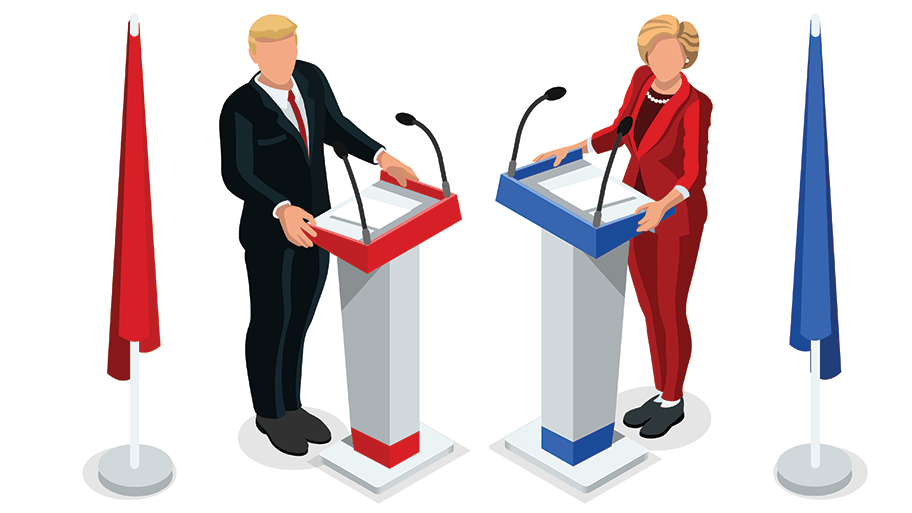

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import re

from wordcloud import WordCloud,STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer

# Load Data

In [ ]:
# Load Data
data = pd.read_csv('/content/sample_data/Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]
# data = data[data.sentiment != "Neutral"]

In [ ]:
# Inspect data
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [ ]:
# Adding text-length as a field in the dataset
data['text length'] = data['text'].apply(len)
data.head(10)

,text,sentiment,text length
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral,106
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive,140
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral,84
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive,140
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive,140
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive,135
6,RT @warriorwoman91: I liked her and was happy ...,Negative,140
7,Going on #MSNBC Live with @ThomasARoberts arou...,Neutral,69
8,Deer in the headlights RT @lizzwinstead: Ben C...,Negative,134
9,RT @NancyOsborne180: Last night's debate prove...,Negative,120


# Some visualization

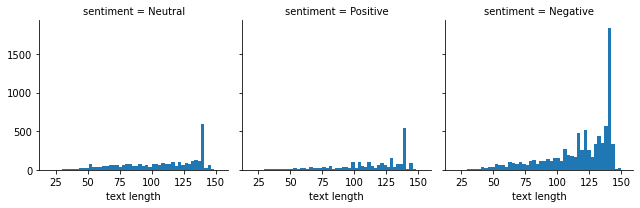

In [ ]:
#Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=data, col='sentiment')
graph.map(plt.hist, 'text length', bins=50)

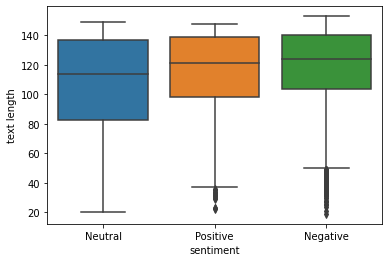

In [ ]:
# Box-plot visvualization
sns.boxplot(x='sentiment', y='text length', data=data)

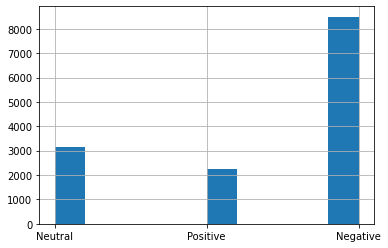

In [ ]:
data.sentiment.hist()

# Wordcloud masking visualization

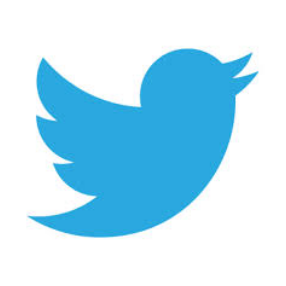

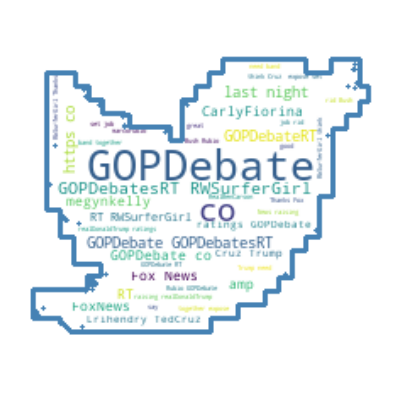

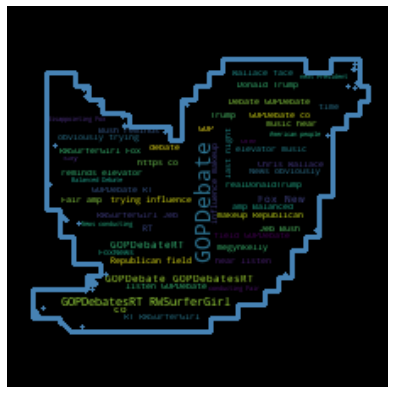

In [ ]:
from os import path
from PIL import Image

# Read the whole text.
text ="".join(data[data['sentiment']=='Positive']['text'])
text2="".join(data[data['sentiment']=='Negative']['text'])

# read the mask image
mask = np.array(Image.open("/content/sample_data/download.jpeg"))

stopwords = set(STOPWORDS)
stopwords.add("said")


# generate word cloud
wc1 = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue').generate("".join(data[data['sentiment']=='Positive']['text']))
wc2 = WordCloud(background_color="black", max_words=2000, mask=mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue').generate("".join(data[data['sentiment']=='Negative']['text']))


# show
plt.figure(figsize=(5,5))
plt.imshow(mask, interpolation='bilinear')
plt.axis("off")

plt.figure(figsize=(7,7))
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")

plt.figure(figsize=(7,7))
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

# Preprocessing

> A few things to notice here
- "RT @..." in start of every tweet
- a lot of special characters <br>
> We have to remove all this noise also lets convert text into lower case.


In [ ]:
# Pre-Processing
data['text'] = data['text'].apply(lambda x: x.lower())
# removing special chars
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['text'] = data['text'].str.replace('rt','')
data.head()

,text,sentiment,text length
0,nancyleegrahn how did everyone feel about the...,Neutral,106
1,scottwalker didnt catch the full gopdebate la...,Positive,140
2,tjmshow no mention of tamir rice and the gopd...,Neutral,84
3,robgeorge that carly fiorina is trending hou...,Positive,140
4,danscavino gopdebate w realdonaldtrump delive...,Positive,140


# TF-IDF Vectorization

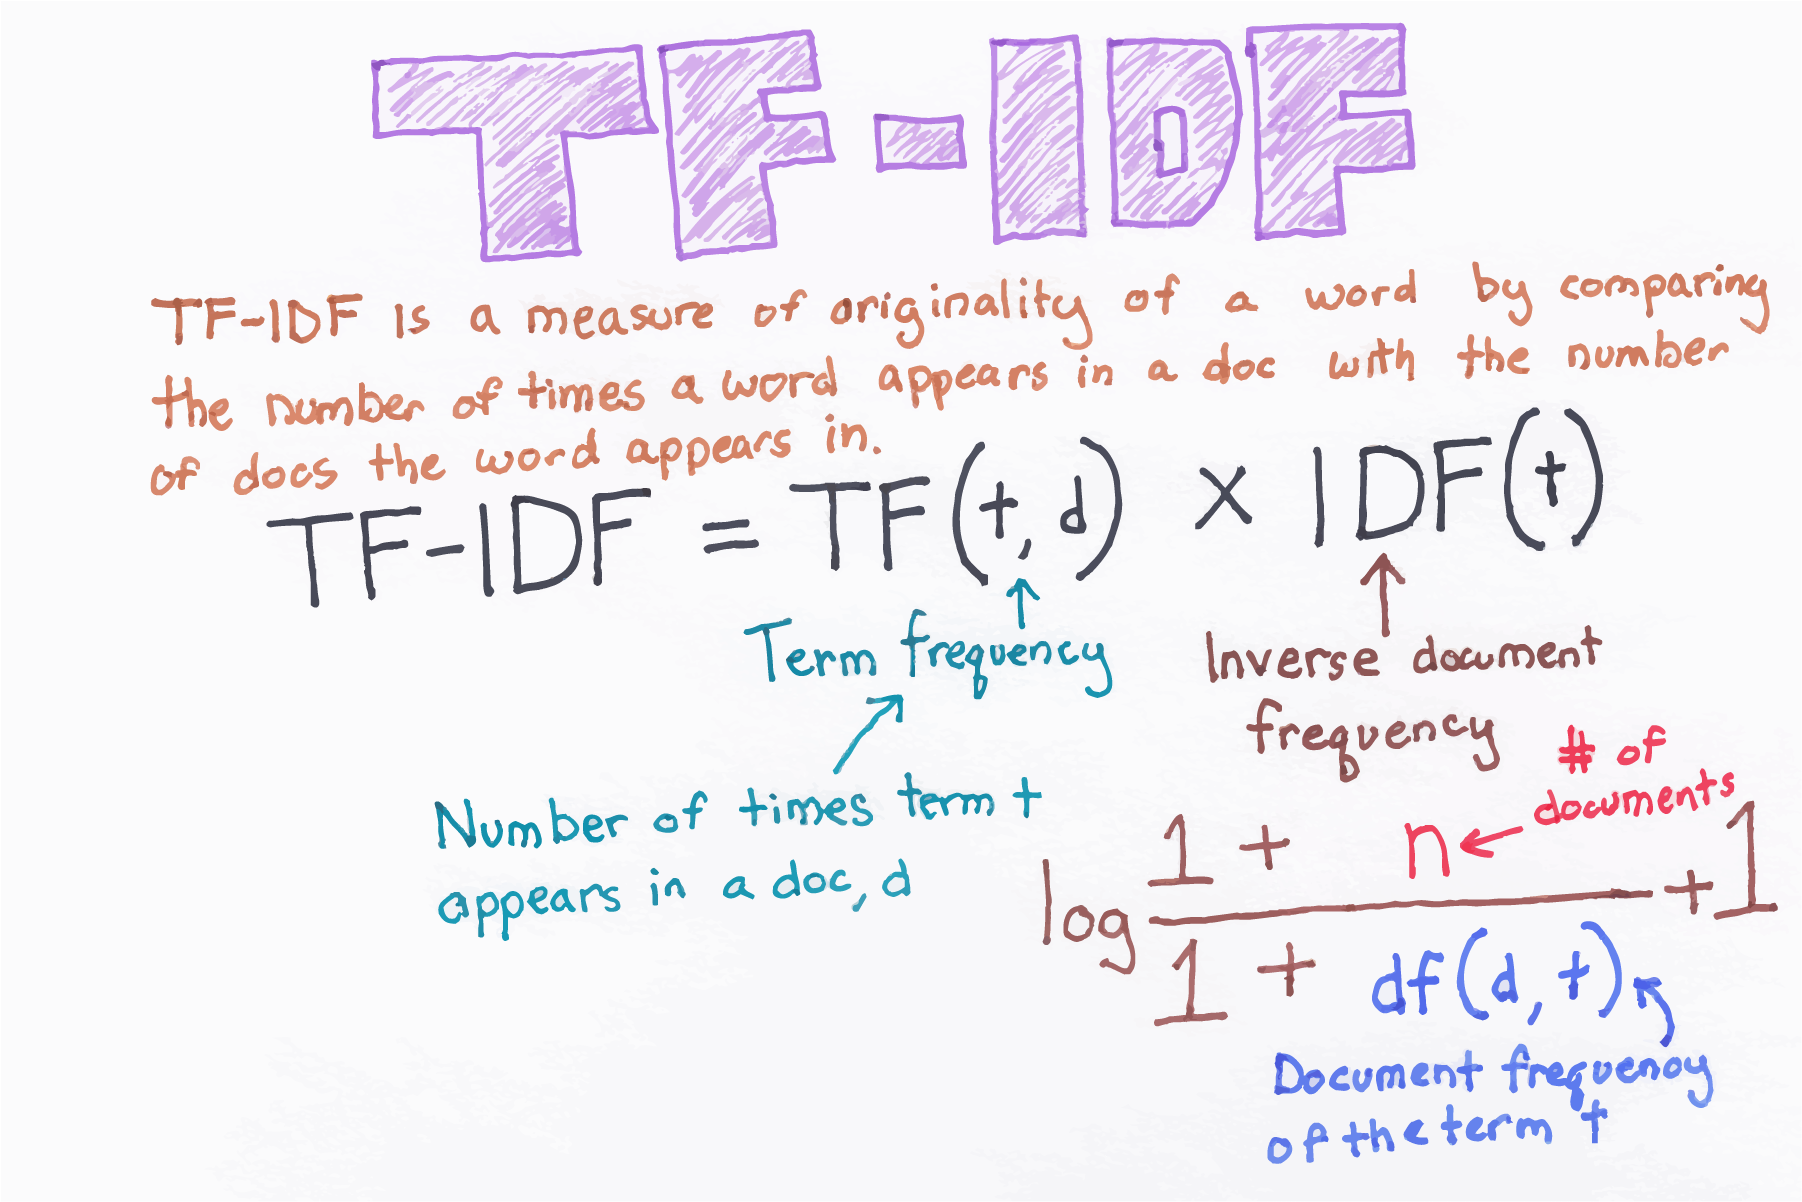

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(data['text'] )
d = {'Neutral':0,'Positive':1,'Negative':2}
data.sentiment = data.sentiment.map(d)
data.head()
X=tfidf
y = data['sentiment'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Model fitting 
# RandomForest classifier 

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_tfidf,y_train)
y_preds = clf.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Random Classifier, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.57      0.28      0.37       612
           1       0.61      0.32      0.42       441
           2       0.70      0.91      0.79      1722

    accuracy                           0.68      2775
   macro avg       0.63      0.50      0.53      2775
weighted avg       0.66      0.68      0.64      2775

Random Classifier, Accuracy Score: 0.6781981981981982


**As we see it is giving good accuracy.**
**But, still I tried model of deeep learning.**


# Tokenization

This looks better.<br>
Lets pre-process the data so that we can use it to train the model
- Tokenize
- Padding (to make all sequence of same lengths)
- Converting sentiments into numerical data(One-hot form)
- train test split


In [ ]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)

# Padding

In [ ]:
# Padding
X = pad_sequences(X)

Y = pd.get_dummies(data['sentiment']).values

# Train/Test Split

In [ ]:
# Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11096, 28) (11096, 3)
(2775, 28) (2775, 3)


# Defining Neural Network Architecture

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


# Training

In [ ]:
batch_size = 128
NoOfEpochs = 30
model.fit(X_train, Y_train, epochs = NoOfEpochs, batch_size=batch_size, verbose = 1)

Epoch 1/30
87/87 [==============================] - 13s 126ms/step - loss: 0.9329 - accuracy: 0.6017
Epoch 2/30
87/87 [==============================] - 11s 123ms/step - loss: 0.7413 - accuracy: 0.6786
Epoch 3/30
87/87 [==============================] - 11s 127ms/step - loss: 0.6462 - accuracy: 0.7258
Epoch 4/30
87/87 [==============================] - 11s 129ms/step - loss: 0.6082 - accuracy: 0.7427
Epoch 5/30
87/87 [==============================] - 11s 131ms/step - loss: 0.5741 - accuracy: 0.7553
Epoch 6/30
87/87 [==============================] - 11s 131ms/step - loss: 0.5738 - accuracy: 0.7613
Epoch 7/30
87/87 [==============================] - 11s 130ms/step - loss: 0.5497 - accuracy: 0.7694
Epoch 8/30
87/87 [==============================] - 11s 131ms/step - loss: 0.5318 - accuracy: 0.7747
Epoch 9/30
87/87 [==============================] - 12s 134ms/step - loss: 0.5128 - accuracy: 0.7833
Epoch 10/30
87/87 [==============================] - 11s 129ms/step - loss: 0.4887 - accura

# Validation

In [ ]:
Y_pred = model.predict_classes(X_test,batch_size = batch_size)
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


confusion matrix [[ 255   71  286]
 [  74  240  127]
 [ 219  139 1364]]
              precision    recall  f1-score   support

           0       0.47      0.42      0.44       612
           1       0.53      0.54      0.54       441
           2       0.77      0.79      0.78      1722

    accuracy                           0.67      2775
   macro avg       0.59      0.58      0.59      2775
weighted avg       0.66      0.67      0.67      2775

